In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = "Maternal Health Risk Data Set.csv"   # adjust path if needed

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nTarget distribution:")
print(df["RiskLevel"].value_counts())

# Encode target
le = LabelEncoder()
df["y_enc"] = le.fit_transform(df["RiskLevel"])
class_names = list(le.classes_)
n_classes = len(class_names)
print("\nClass mapping:", {cls: i for i, cls in enumerate(class_names)})

# Features and target
X = df.drop(["RiskLevel", "y_enc"], axis=1).values.astype(float)
y = df["y_enc"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

def one_hot(y, n_classes):
    oh = np.zeros((y.shape[0], n_classes))
    oh[np.arange(y.shape[0]), y] = 1
    return oh

y_train_oh = one_hot(y_train, n_classes)
y_test_oh = one_hot(y_test, n_classes)

n_features = X_train.shape[1]
print("Number of features:", n_features)


Shape: (1014, 7)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk



Columns: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']

Target distribution:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

Class mapping: {'high risk': 0, 'low risk': 1, 'mid risk': 2}

Train shape: (811, 6) Test shape: (203, 6)
Number of features: 6


In [3]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred, n_classes):
    prec = []
    rec = []
    f1 = []
    for c in range(n_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        prec.append(p)
        rec.append(r)
        f1.append(f)
    return {
        "precision_macro": float(np.mean(prec)),
        "recall_macro": float(np.mean(rec)),
        "f1_macro": float(np.mean(f1)),
        "precision_per_class": prec,
        "recall_per_class": rec,
        "f1_per_class": f1,
    }


In [4]:
import time

class SoftmaxBaseline:
    def __init__(self, n_features, n_classes, lr=0.1, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.loss_history = []
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))

    def softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)
        expz = np.exp(z)
        return expz / np.sum(expz, axis=1, keepdims=True)

    def compute_loss(self, y_true_oh, probs):
        m = y_true_oh.shape[0]
        loss = -np.sum(y_true_oh * np.log(probs + 1e-15)) / m
        return float(loss)

    def fit(self, X, y_oh):
        m = X.shape[0]
        for i in range(self.n_iter):
            logits = X.dot(self.W) + self.b
            probs = self.softmax(logits)
            loss = self.compute_loss(y_oh, probs)

            dlogits = (probs - y_oh) / m
            dW = X.T.dot(dlogits)
            db = np.sum(dlogits, axis=0, keepdims=True)

            self.W -= self.lr * dW
            self.b -= self.lr * db

            self.loss_history.append(loss)
            if (i + 1) % max(1, self.n_iter // 5) == 0 or i == 0:
                print(f"Baseline iter {i+1}/{self.n_iter} loss: {loss:.4f}")
        return self

    def predict_proba(self, X):
        logits = X.dot(self.W) + self.b
        return self.softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

baseline = SoftmaxBaseline(n_features=n_features, n_classes=n_classes, lr=0.5, n_iter=800)
start = time.time()
baseline.fit(X_train, y_train_oh)
baseline_time = time.time() - start

y_pred_baseline = baseline.predict(X_test)
baseline_metrics = {
    "accuracy": float(accuracy(y_test, y_pred_baseline)),
    **precision_recall_f1(y_test, y_pred_baseline, n_classes),
}

print("\nBaseline results:")
print("  Test accuracy:", baseline_metrics["accuracy"])
print("  Precision (macro):", baseline_metrics["precision_macro"])
print("  Recall (macro):   ", baseline_metrics["recall_macro"])
print("  F1 (macro):       ", baseline_metrics["f1_macro"])
print("  Training time (s):", baseline_time)


Baseline iter 1/800 loss: 1.0964
Baseline iter 160/800 loss: 0.7708
Baseline iter 320/800 loss: 0.7706
Baseline iter 480/800 loss: 0.7705
Baseline iter 640/800 loss: 0.7705
Baseline iter 800/800 loss: 0.7705

Baseline results:
  Test accuracy: 0.6157635467980296
  Precision (macro): 0.6152097902097903
  Recall (macro):    0.6161124791307213
  F1 (macro):        0.6065520065520067
  Training time (s): 0.07710909843444824


In [5]:
class MLP:
    def __init__(self, architecture, lr=0.01, n_iter=1000, seed=42):
        self.architecture = architecture
        self.lr = lr
        self.n_iter = n_iter
        self.loss_history = []
        np.random.seed(seed)
        self.params = {}
        self.initialize_parameters()

    def initialize_parameters(self):
        self.L = len(self.architecture) - 1
        params = {}
        for l in range(1, len(self.architecture)):
            params["W" + str(l)] = np.random.randn(
                self.architecture[l-1], self.architecture[l]
            ) * np.sqrt(2.0 / self.architecture[l-1])
            params["b" + str(l)] = np.zeros((1, self.architecture[l]))
        self.params = params

    def relu(self, x):
        return np.maximum(0, x)

    def drelu(self, x):
        return (x > 0).astype(float)

    def softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)
        expz = np.exp(z)
        return expz / np.sum(expz, axis=1, keepdims=True)

    def forward(self, X):
        cache = {"A0": X}
        A = X
        for l in range(1, self.L + 1):
            W = self.params["W" + str(l)]
            b = self.params["b" + str(l)]
            Z = A.dot(W) + b
            if l < self.L:
                A = self.relu(Z)
            else:
                A = self.softmax(Z)
            cache["Z" + str(l)] = Z
            cache["A" + str(l)] = A
        return A, cache

    def backward(self, cache, y_oh):
        grads = {}
        m = y_oh.shape[0]
        A_L = cache["A" + str(self.L)]
        dZ = (A_L - y_oh) / m

        for l in range(self.L, 0, -1):
            A_prev = cache["A" + str(l-1)]
            W = self.params["W" + str(l)]

            grads["dW" + str(l)] = A_prev.T.dot(dZ)
            grads["db" + str(l)] = np.sum(dZ, axis=0, keepdims=True)

            if l > 1:
                dA_prev = dZ.dot(W.T)
                Z_prev = cache["Z" + str(l-1)]
                dZ = dA_prev * self.drelu(Z_prev)

        return grads

    def update_params(self, grads):
        for l in range(1, self.L + 1):
            self.params["W" + str(l)] -= self.lr * grads["dW" + str(l)]
            self.params["b" + str(l)] -= self.lr * grads["db" + str(l)]

    def compute_loss(self, y_oh, probs):
        m = y_oh.shape[0]
        loss = -np.sum(y_oh * np.log(probs + 1e-15)) / m
        return float(loss)            

    def fit(self, X, y_oh, verbose=True):
        for i in range(self.n_iter):
            probs, cache = self.forward(X)
            loss = self.compute_loss(y_oh, probs)
            grads = self.backward(cache, y_oh)
            self.update_params(grads)
            self.loss_history.append(loss)

            if verbose and ((i + 1) % max(1, self.n_iter // 5) == 0 or i == 0):
                print(f"MLP iter {i+1}/{self.n_iter} loss: {loss:.4f}")
        return self

    def predict_proba(self, X):
        probs, _ = self.forward(X)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

arch = [n_features, 16, n_classes]
mlp = MLP(architecture=arch, lr=0.05, n_iter=1200)

start = time.time()
mlp.fit(X_train, y_train_oh, verbose=True)
mlp_time = time.time() - start

y_pred_mlp = mlp.predict(X_test)
mlp_metrics = {
    "accuracy": float(accuracy(y_test, y_pred_mlp)),
    **precision_recall_f1(y_test, y_pred_mlp, n_classes),
}

print("\nMLP results:")
print("  Test accuracy:", mlp_metrics["accuracy"])
print("  Precision (macro):", mlp_metrics["precision_macro"])
print("  Recall (macro):   ", mlp_metrics["recall_macro"])
print("  F1 (macro):       ", mlp_metrics["f1_macro"])
print("  Training time (s):", mlp_time)


MLP iter 1/1200 loss: 1.9078
MLP iter 240/1200 loss: 0.7496
MLP iter 480/1200 loss: 0.7016
MLP iter 720/1200 loss: 0.6773
MLP iter 960/1200 loss: 0.6593
MLP iter 1200/1200 loss: 0.6450

MLP results:
  Test accuracy: 0.6748768472906403
  Precision (macro): 0.6908378736109828
  Recall (macro):    0.6784361023166993
  F1 (macro):        0.6775155014801472
  Training time (s): 0.186906099319458


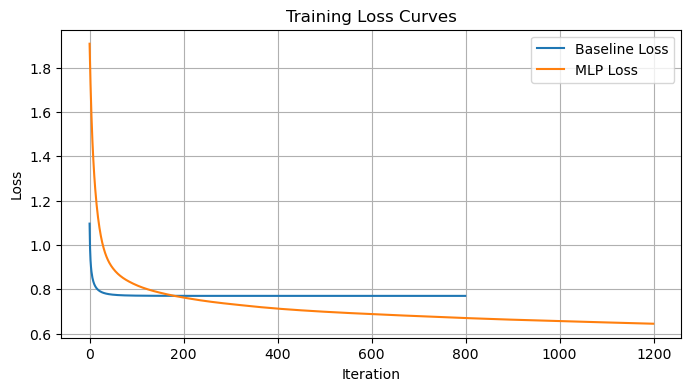

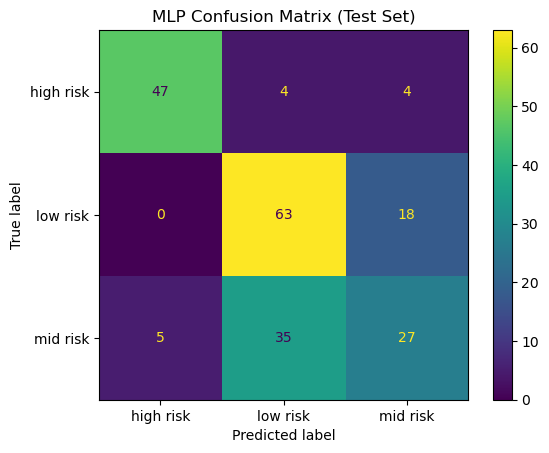

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(baseline.loss_history, label="Baseline Loss")
plt.plot(mlp.loss_history, label="MLP Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=class_names)
disp.plot(values_format="d", cmap="viridis")
plt.title("MLP Confusion Matrix (Test Set)")
plt.show()


In [7]:
def get_assignment_results():
    return {
        "dataset_name": "Maternal Health Risk Data Set",
        "n_samples": int(df.shape[0]),
        "n_features": int(n_features),
        "problem_type": "multi_class_classification",
        "primary_metric": "accuracy",
        "baseline_model": {
            "model_type": "softmax_regression_scratch",
            "test_accuracy": float(baseline_metrics["accuracy"]),
            "precision_macro": float(baseline_metrics["precision_macro"]),
            "recall_macro": float(baseline_metrics["recall_macro"]),
            "f1_macro": float(baseline_metrics["f1_macro"]),
            "training_time_seconds": float(baseline_time),
        },
        "mlp_model": {
            "architecture": arch,
            "test_accuracy": float(mlp_metrics["accuracy"]),
            "precision_macro": float(mlp_metrics["precision_macro"]),
            "recall_macro": float(mlp_metrics["recall_macro"]),
            "f1_macro": float(mlp_metrics["f1_macro"]),
            "training_time_seconds": float(mlp_time),
        },
    }

results = get_assignment_results()
results


{'dataset_name': 'Maternal Health Risk Data Set',
 'n_samples': 1014,
 'n_features': 6,
 'problem_type': 'multi_class_classification',
 'primary_metric': 'accuracy',
 'baseline_model': {'model_type': 'softmax_regression_scratch',
  'test_accuracy': 0.6157635467980296,
  'precision_macro': 0.6152097902097903,
  'recall_macro': 0.6161124791307213,
  'f1_macro': 0.6065520065520067,
  'training_time_seconds': 0.07710909843444824},
 'mlp_model': {'architecture': [6, 16, 3],
  'test_accuracy': 0.6748768472906403,
  'precision_macro': 0.6908378736109828,
  'recall_macro': 0.6784361023166993,
  'f1_macro': 0.6775155014801472,
  'training_time_seconds': 0.186906099319458}}